## Visualization 1: Victoria Annual Waste Flows (2015–2024)

Victoria’s total waste generation has grown over time, but local recovery (including Waste-to-Energy) is steadily increasing while exports are declining.  
However, disposal levels remain relatively stable, showing that stronger community participation in recycling is still needed to further cut landfill.  
For new migrants, this highlights both the progress of Victoria’s waste system and the importance of individual sorting habits.

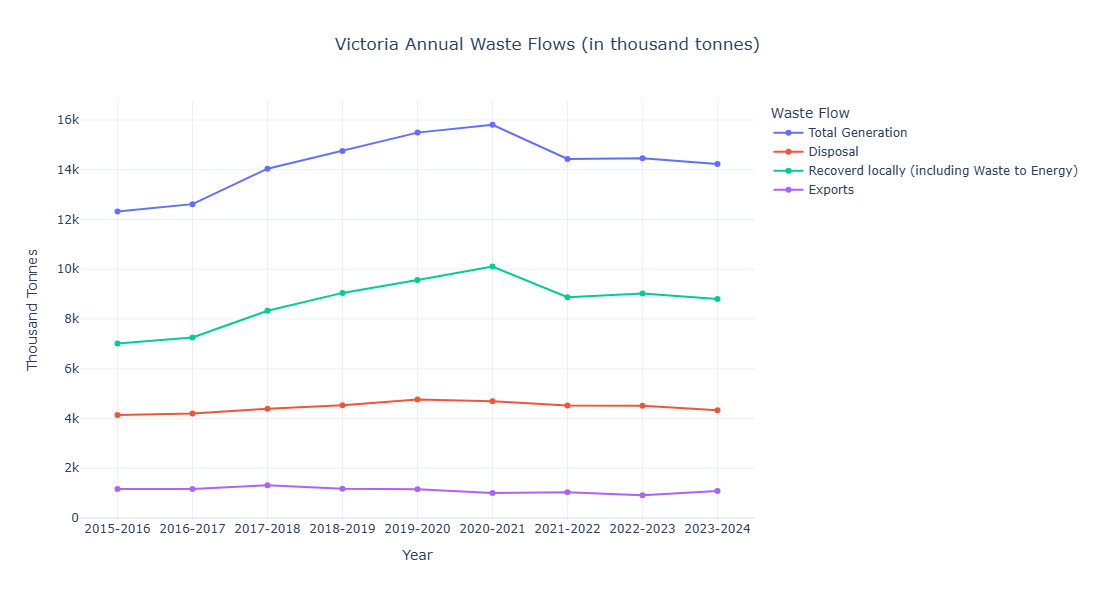

In [53]:
import pandas as pd
import plotly.express as px

# Read dataset
df = pd.read_csv("Merged_vic_waste_summary.csv")

# Convert from tonnes to thousand tonnes
df["Total Generation"] = df["Total Generation"] / 1000
df["Disposal"] = df["Disposal"] / 1000
df["Recoverd locally (including Waste to Energy)"] = df["Recoverd locally (including Waste to Energy)"] / 1000
df["Exports"] = df["Exports"] / 1000

# Create line chart
fig = px.line(
    df,
    x="Financial Year",
    y=["Total Generation", "Disposal", 
       "Recoverd locally (including Waste to Energy)", "Exports"],
    markers=True,
    title="Victoria Annual Waste Flows (in thousand tonnes)",
    labels={
        "value": "Thousand Tonnes",
        "Financial Year": "Year",
        "variable": "Category"
    },
    hover_data={"Financial Year": True, "value":":.1f"}  # 1 decimal place
)

# Layout adjustments
fig.update_layout(
    hovermode="x unified",
    legend_title_text="Waste Flow",
    template="plotly_white",
    title_x=0.5,    
    height=600 
)

fig.show()


## Visualization 2: Waste Flows by Material Type (Victoria)

This chart shows how Victoria manages different waste types (e.g., organics, paper, plastics, metals) over time.  
It helps newcomers understand **which materials matter most**, how much is recycled vs. landfilled, and why proper sorting is important.  
By linking individual behaviour to broader outcomes, it encourages sustainable habits from day one.

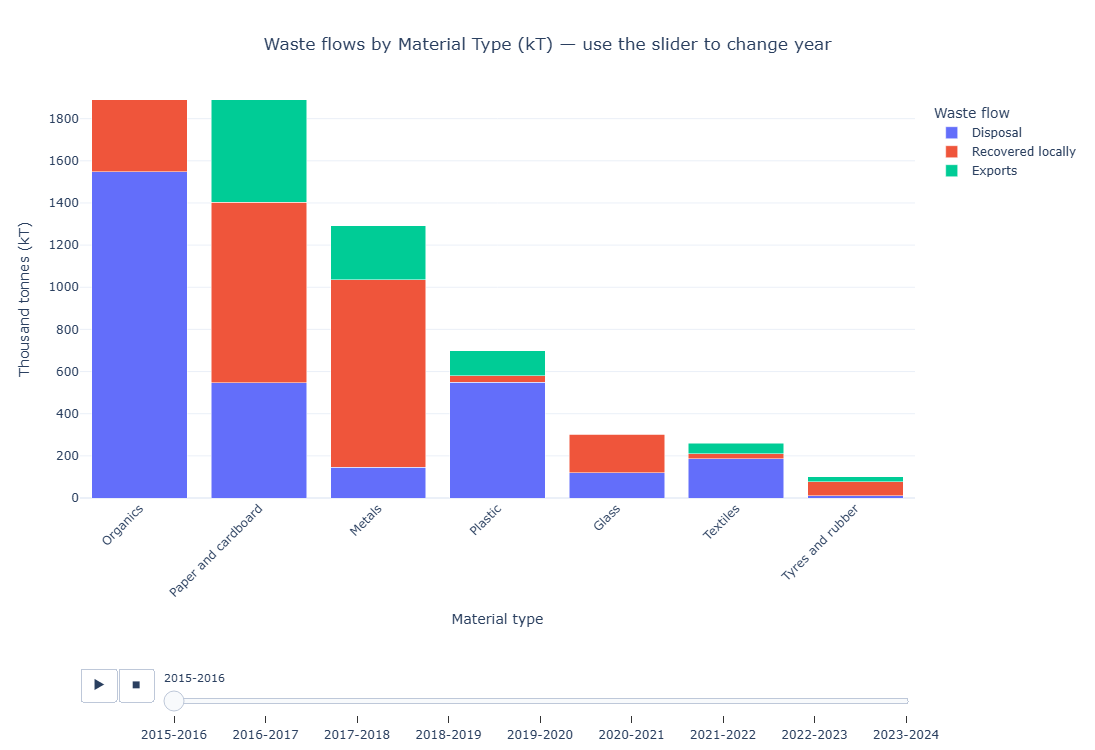

In [37]:
# --- 1) Load & prepare ---
df = pd.read_csv("Victoria-Waste-v2025.1_clean.csv")

# Find the processed-locally column (handles the known 'Recoverd' typo)
proc_col = next(c for c in df.columns if "locally" in c and "Energy" in c)

# Calculate Exports = International + Interstate
df["Exports"] = df["International Export"].fillna(0) + df["Interstate Export"].fillna(0)

# Exclude the large construction-like category
df = df[df["Material Type"] != "Aggregate, masonry and soils"].copy()

# Aggregate to Year × Material
g = (df.groupby(["Financial Year", "Material Type"], as_index=False)
       .agg({
           "Disposal":"sum",
           proc_col:"sum",
           "Exports":"sum"
       }))

# Convert values to thousand tonnes
for col in ["Disposal", proc_col, "Exports"]:
    g[col] = g[col] / 1000.0

# Create a stable order of materials across years (rank by overall total)
g["Total"] = g["Disposal"] + g[proc_col] + g["Exports"]
order_by_overall = (g.groupby("Material Type")["Total"].sum()
                      .sort_values(ascending=False).index.tolist())

# Transform into long format for stacked bars
long_df = g.melt(
    id_vars=["Financial Year", "Material Type"],
    value_vars=["Disposal", proc_col, "Exports"],
    var_name="Category",
    value_name="Thousand tonnes"
)

# Rename the processed column for a nicer legend text
rename_map = {proc_col: "Recovered locally"}
long_df["Category"] = long_df["Category"].replace(rename_map)

# Ensure year order is chronological
year_order = sorted(long_df["Financial Year"].unique())

# --- 2) Plot: stacked bar with animation (time slider) ---
fig = px.bar(
    long_df,
    x="Material Type",
    y="Thousand tonnes",
    color="Category",
    animation_frame="Financial Year",          # add time slider
    category_orders={
        "Material Type": order_by_overall,     # keep stable material ordering
        "Financial Year": year_order
    },
    title="Waste flows by Material Type (kT) — use the slider to change year",
    labels={"Material Type":"Material type", "Thousand tonnes":"Thousand tonnes (kT)", "Category":"Flow"},
    template="plotly_white"
)

fig.update_layout(
    barmode="stack",
    xaxis_tickangle=-45,
    hovermode="x unified",
    legend_title_text="Waste flow",
    title_x=0.5
)

# Add bottom margin for the slider and increase overall height
fig.update_layout(
    margin=dict(b=180),
    height=750,  # make figure taller (default ~450, try 650~800)
)

# Optional: set y-axis max to 110% of the maximum value to avoid bars touching the top
fig.update_yaxes(range=[0, long_df["Thousand tonnes"].max() * 1.1])

# Adjust bottom margin for the slider
fig.update_layout(margin=dict(b=180))  # fine-tune between 160–200

# Move the slider position and add vertical spacing
sl = fig.layout.sliders[0]
sl.update(y=-0.05, pad=dict(t=150, b=0))  # adjust y to move slider up/down; pad.t controls spacing

# Align play/pause buttons with slider
um = fig.layout.updatemenus[0]
um.update(y=-0.05, x=0.0, xanchor="left", yanchor="top", pad=dict(t=150, r=10))

# Optional: shorten or resize the slider's current value text
sl.currentvalue.update(prefix="", font=dict(size=11))  # remove "Financial Year=" prefix and use smaller font

# Format hover values with 1 decimal place
fig.update_traces(hovertemplate="%{x}<br>%{legendgroup}: %{y:.1f} kT")

fig.show()


## Visualization 3: Recovery Rate Trends by Source Sector (2015–2024)

C&D (Construction & Demolition) consistently achieves the highest recovery rates, staying above 80% across the years.  
C&I (Commercial & Industrial) shows more fluctuation, with recovery levels moving between 55–65%.  
MSW (Municipal Solid Waste) lags behind at 40–55%, highlighting that household recycling behaviour is the key area for improvement, especially relevant for new migrants learning local waste practices.

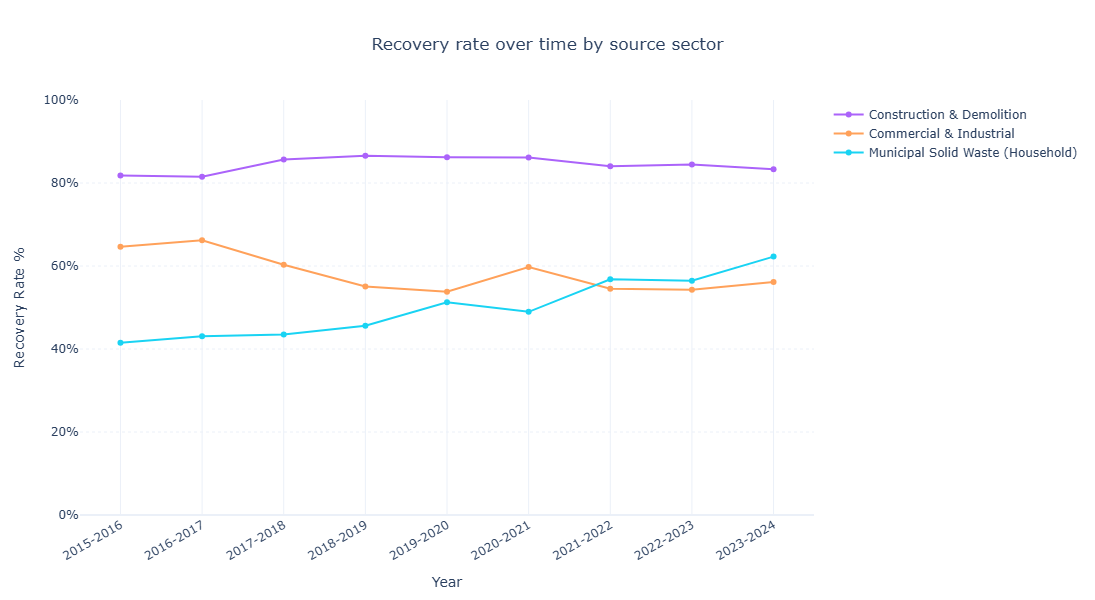

In [44]:
# --- 1) Load & prepare ---
df = pd.read_csv("Victoria-Waste-v2025.1_clean.csv")

# Find the processed-locally column (handles the 'Recoverd ...' typo)
proc_col = next(c for c in df.columns if "locally" in c and "Energy" in c)

# Compute Exports = International + Interstate
df["Exports"] = df["International Export"].fillna(0) + df["Interstate Export"].fillna(0)

# --- 2) Aggregate by year x source sector and compute recovery rate ---
sector = (df.groupby(["Financial Year", "Source Sector"], as_index=False)
            .agg({
                "Total Generation":"sum",
                "Disposal":"sum",
                proc_col:"sum",
                "Exports":"sum"
            }))

sector["Recovery Rate %"] = (sector[proc_col] + sector["Exports"]) / sector["Total Generation"] * 100


rename_map = {
    "CND": "Construction & Demolition",
    "CNI": "Commercial & Industrial",
    "MSW": "Municipal Solid Waste (Household)"
}
sector["Source Sector"] = sector["Source Sector"].replace(rename_map)

# Keep chronological year order
year_order = sorted(sector["Financial Year"].unique())

# --- 3) Plot: recovery rate over time by source sector ---
# High-contrast but still clean colors
palette = {
    "CND": "#1f77b4",  # blue
    "CNI": "#ff7f0e",  # orange
    "MSW": "#2ca02c"   # green
}

fig = px.line(
    sector,
    x="Financial Year",
    y="Recovery Rate %",
    color="Source Sector",
    category_orders={"Financial Year": year_order, "Source Sector": ["CND","CNI","MSW"]},
    markers=True,
    title="Recovery rate over time by source sector",
    labels={"Financial Year":"Year", "Recovery Rate %":"Recovery Rate %", "Source Sector":"Sector"},
    color_discrete_map=palette,
    template="plotly_white"
)


# Formatting
fig.update_layout(
    hovermode="x unified",
    title_x=0.5,
    yaxis=dict(range=[0, 100], ticksuffix="%", griddash="dot"),
    xaxis_tickangle=-30,
    height=600,
    legend_title_text=""
)

# Hover with 0 decimals on percentage
fig.update_traces(hovertemplate="%{x}<br>%{legendgroup}: %{y:.0f}%")

fig.show()


## Visualization 4: Emission Intensity vs Waste Proportion (Household Waste)

Food and paper waste dominate the household waste stream by proportion, making them the biggest contributors to overall emissions despite having moderate emission factors.
Items like nappies and rubber/leather, although smaller in proportion, show higher emission intensity, highlighting their potential as reduction priorities.
This suggests that improving recycling or diversion strategies for high-volume categories (food, paper) and high-intensity categories (nappies, rubber/leather) would deliver the most significant climate benefits.

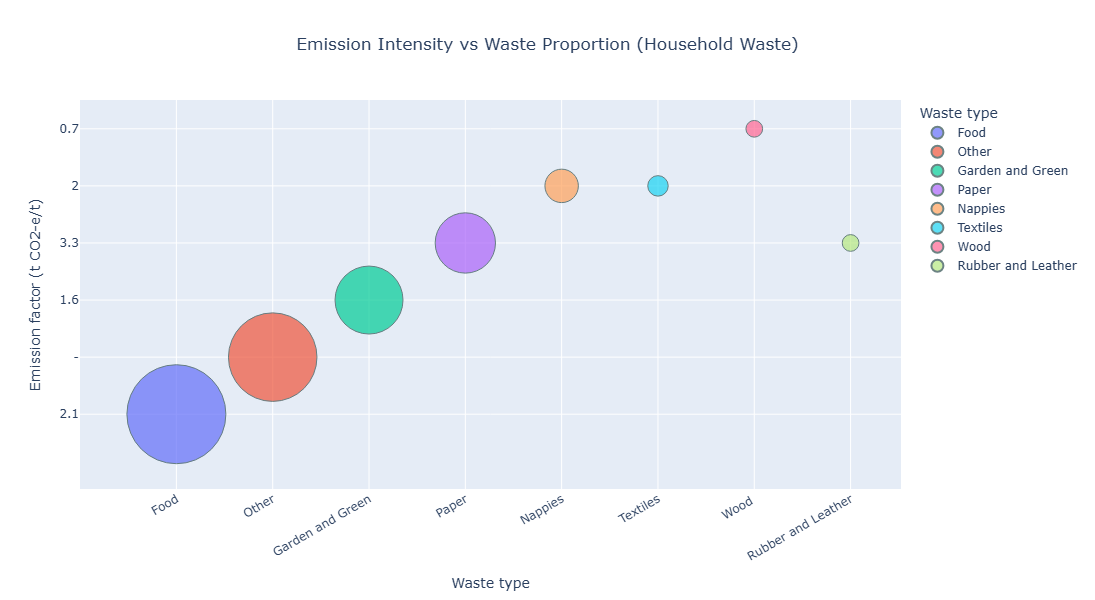

In [41]:
import pandas as pd
import plotly.express as px

# Load merged CSV
df = pd.read_csv("merged_emission_factors.csv")

# Remove "Sludge"
df = df[df["Waste type (unified)"] != "Sludge"]

# Plot bubble chart with bigger bubbles
fig = px.scatter(
    df,
    x="Waste type (unified)",
    y="Scope 3 EF (t CO2-e/t)",
    size="Proportion (share)",
    color="Waste type (unified)",
    hover_data=["Proportion (share)", "Weighted EF (t CO2-e)"],
    title="Emission Intensity vs Waste Proportion (Household Waste)",
    labels={
        "Waste type (unified)": "Waste type",
        "Scope 3 EF (t CO2-e/t)": "Emission factor (t CO2-e/t)"
    },
    size_max=70  # <-- increase bubble size difference
)

# Formatting
fig.update_traces(marker=dict(line=dict(width=1, color="DarkSlateGrey")))
fig.update_layout(title_x=0.5, xaxis_tickangle=-30, height=600)

fig.show()
